In [1]:
import os
import numpy as np
import torch
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from typing import Optional,Callable,Any
from os import DirEntry

from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torchvision.io import read_image

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

import torch.optim as optim

import time

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_on_gpu = torch.cuda.is_available()
print(device, train_on_gpu)

cuda True


In [3]:
data_dir='/home/max/Documents/Datasets/aerial-cactus-identification/'

In [4]:
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [38]:
class CactusDataset(datasets.VisionDataset):
    def __init__(
        self, root, annotations_file, img_dir, transform=None, target_transform=None, is_train=True
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        
        self.img_size = 32
        self.is_train = is_train
                    
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        
        
        self.img_dir = os.path.join(root, img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
            
class CactusTestDataset(datasets.VisionDataset):
    def __init__(self, root, img_dir, transform=None) -> None:
        super().__init__(root, transform=transform)
        
        self.img_size = 32
        
        self.img_dir = os.path.join(root, img_dir)
        self.transform = transform
        
        self.idx = dict()
        
        self.__scan_img_dir__()
    
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.idx[idx])
        image = read_image(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.idx[idx]
        
    def __scan_img_dir__(self):
        with os.scandir(self.img_dir) as d:
            i = 0
            for entry in d:
                if entry.is_file():
                    self.idx[i] = entry.name
                    i += 1
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17500 15500 2000


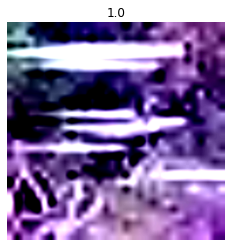

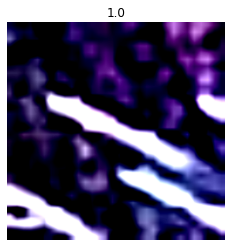

In [39]:
target_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype(np.float32))
])


dc = CactusDataset(data_dir, 'train.csv', 'train', transform=EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(),
                  target_transform=target_transform
                  )
train_dc, val_dc = torch.utils.data.random_split(dc, [15500, 2000], generator=torch.Generator().manual_seed(seed))

# train_dc = dc

print(dc.__len__(), train_dc.__len__(), val_dc.__len__())

for i in range(2):
    image, label = dc.__getitem__(i)
    imshow(image, title=label, normalize=False)

Test dc 4000


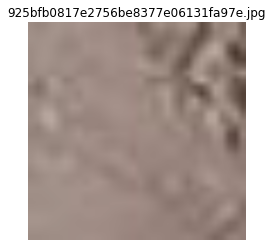

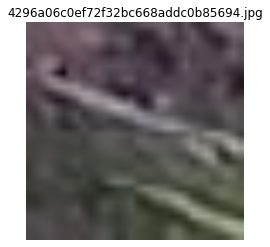

In [40]:
test_dc = CactusTestDataset(data_dir, 'test', transform=EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms())

print("Test dc", test_dc.__len__())

for i in range(2):
    image, idx = test_dc.__getitem__(i)
    imshow(image, title=idx)

In [41]:
batch_size=32

train_dataloader = DataLoader(train_dc, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dc, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dc, batch_size=batch_size, shuffle=False)


torch.Size([32, 3, 384, 384]) torch.Size([32])


<AxesSubplot:title={'center':'tensor(1.)'}>

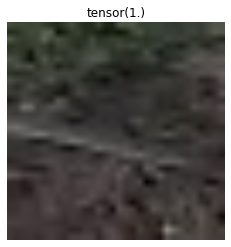

In [30]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape, train_labels.shape)

imshow(train_features[0], title=train_labels[0])

In [31]:
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

import torch.nn as nn

classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

model.classifier = classifier

In [32]:
model.load_state_dict(torch.load('./cactus_full.pt'))

<All keys matched successfully>

In [33]:
for param in model.parameters():
    param.requires_grad = False
    

# for param in model.features[5].parameters():
#     param.requires_grad = True 
    
# for param in model.features[6].parameters():
#     param.requires_grad = True


for param in model.features[6][6].parameters():
    param.requires_grad = True

for param in model.features[6][7].parameters():
    param.requires_grad = True

for param in model.features[6][8].parameters():
    param.requires_grad = True

for param in model.features[6][9].parameters():
    param.requires_grad = True

for param in model.features[6][10].parameters():
    param.requires_grad = True

for param in model.features[6][11].parameters():
    param.requires_grad = True

for param in model.features[6][12].parameters():
    param.requires_grad = True

for param in model.features[6][13].parameters():
    param.requires_grad = True

for param in model.features[6][14].parameters():
    param.requires_grad = True
    
    
    
for param in model.features[7].parameters():
    param.requires_grad = True
    
    
for param in model.avgpool.parameters():
    param.requires_grad = True    
    

for param in model.classifier.parameters():
    param.requires_grad = True    

In [34]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [35]:
# model.features[6][14].__dict__

In [36]:
torch.cuda.empty_cache()

In [37]:
def process_output(output):
    o = output.squeeze()
    return o.to(torch.float32)
    

class NetTrainer:
    def __init__(self, model, criterion, optimizer):
        
        self.model = model
        self.criterion = criterion 
        self.optimizer = optimizer
        
        self.num_classes = 2
        self.class_correct = list(0. for i in range(self.num_classes))
        self.class_total = list(0. for i in range(self.num_classes))
        self.classes = list(i for i in range(self.num_classes))
        
        self.train_losses = [] 
        self.eval_losses = []
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.train_on_gpu = torch.cuda.is_available()
        
        print("Train on: ", device, train_on_gpu)
        
        self.model.to(device)
        
        
    def train(self, epochs, train_dataloader, val_dataloader):
        self.train_len = len(train_dataloader)
        
        val_msg = ""
        
        for e in range(epochs):
            model.train()
            running_loss = 0
            tic = time.perf_counter()
            i = 0
            for data, target in train_dataloader:
                i += 1

                if self.train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                optimizer.zero_grad()

                output = process_output(model(data))
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.cpu().item()
                
#                 return
#                 break;
            else: 
                if val_dataloader is not None:
                    val_loss, val_accuracy = self.evaluate(val_dataloader)
                    self.eval_losses.append(val_loss)

                    val_msg = "Val Loss: {:.3f}.. ".format(self.eval_losses[-1]) + " Val Accuracy: {:.3f}".format(val_accuracy)

            self.train_losses.append(running_loss/self.train_len)
            toc = time.perf_counter()
            
            duration = " {:.2f} min".format( (toc - tic)/60 )
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(self.train_losses[-1]),
                  val_msg,
                 duration)
            
        if val_dataloader is not None:
            self.print_val_summary()
    
    
    def print_val_summary(self):
        for i in range(self.num_classes):
            if self.class_total[i] > 0:
                print('Val Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    self.classes[i], 100 * self.class_correct[i] / self.class_total[i],
                    np.sum(self.class_correct[i]), np.sum(self.class_total[i])))
            else:
                print('Val Accuracy of %5s: N/A (no training examples)' % (self.classes[i]))
        
        
        
    def evaluate(self, test_dataloader):
        test_len = len(test_dataloader)

        test_loss = 0
        accuracy = 0
        test_losses = []
        
        with torch.no_grad():
            model.eval()
            for data, target in test_dataloader:

                if self.train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                output = process_output(model(data))
                test_loss += criterion(output, target).cpu()
                
                top_class = torch.round(output)
                
                equals = top_class == target.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                for i in range(target.data.shape[0]):
                    label = int(target.data[i].item())
                    self.class_correct[label] += 1 if equals[i] == True else 0
                    self.class_total[label] += 1


        return test_loss/test_len, accuracy/test_len

In [25]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, cycle_momentum=False, verbose=True)

trainer = NetTrainer(model, criterion, scheduler)

trainer.train(5, train_dataloader, val_dataloader)

# Adjusting learning rate of group 0 to 1.0000e-03.
# Train on:  cuda True
# Epoch: 1/5..  Training Loss: 0.087..  Val Loss: 0.914..  Val Accuracy: 0.966  4.88 min
# Epoch: 2/5..  Training Loss: 0.066..  Val Loss: 0.486..  Val Accuracy: 0.984  4.83 min
# Epoch: 3/5..  Training Loss: 0.073..  Val Loss: 1.194..  Val Accuracy: 0.952  4.85 min
# Epoch: 4/5..  Training Loss: 0.078..  Val Loss: 0.096..  Val Accuracy: 0.963  4.85 min
# Epoch: 5/5..  Training Loss: 0.081..  Val Loss: 0.804..  Val Accuracy: 0.973  4.87 min
# Val Accuracy of     0: 90% (2228/2455)
# Val Accuracy of     1: 98% (7450/7545)


# Adjusting learning rate of group 0 to 1.0000e-04.
# Train on:  cuda True
# Epoch: 1/5..  Training Loss: 0.028..  Val Loss: 0.021..  Val Accuracy: 0.992  7.00 min
# Epoch: 2/5..  Training Loss: 0.024..  Val Loss: 0.060..  Val Accuracy: 0.997  6.95 min
# Epoch: 3/5..  Training Loss: 0.022..  Val Loss: 0.111..  Val Accuracy: 0.995  6.96 min
# Epoch: 4/5..  Training Loss: 0.020..  Val Loss: 0.010..  Val Accuracy: 0.996  6.95 min
# Epoch: 5/5..  Training Loss: 0.021..  Val Loss: 0.276..  Val Accuracy: 0.990  6.96 min
# Val Accuracy of     0: 99% (2434/2455)
# Val Accuracy of     1: 99% (7504/7545)

Adjusting learning rate of group 0 to 1.0000e-04.
Train on:  cuda True
Epoch: 1/5..  Training Loss: 0.028..  Val Loss: 0.021..  Val Accuracy: 0.992  7.00 min
Epoch: 2/5..  Training Loss: 0.024..  Val Loss: 0.060..  Val Accuracy: 0.997  6.95 min
Epoch: 3/5..  Training Loss: 0.022..  Val Loss: 0.111..  Val Accuracy: 0.995  6.96 min
Epoch: 4/5..  Training Loss: 0.020..  Val Loss: 0.010..  Val Accuracy: 0.996  6.95 min
Epoch: 5/5..  Training Loss: 0.021..  Val Loss: 0.276..  Val Accuracy: 0.990  6.96 min
Val Accuracy of     0: 99% (2434/2455)
Val Accuracy of     1: 99% (7504/7545)


In [24]:
# torch.save(model.state_dict(), './cactus_full.pt')
AttributionVisualizer?

In [27]:
print("Captum insight")

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# model.to("cpu")

def score_func(o):
    print(o.shape)
    
    o = process_output(o)
    
    print(o)
    
    return o
    
def baseline_func(input):
    return input * 0

def formatted_data_iter():
#     val_iterator = iter(val_dataloader)
    
    val_iterator = iter(DataLoader(val_dc, batch_size=1, shuffle=False, num_workers=2))
    while True:
        images, labels = next(val_iterator)
        
#         print(images.shape, labels.shape)
        
        yield Batch(inputs=images, labels=labels)


normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = [i for i in range(2)]

visualizer = AttributionVisualizer(
    models=[model],
    score_func=score_func,
    classes=classes,
    features=[
        ImageFeature(
            "Cactus",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=formatted_data_iter(),
)

visualizer.render()

# from IPython.display import Image
# Image(filename='img/captum_insights.png')

Captum insight


CaptumInsights(insights_config={'classes': [0, 1], 'methods': ['Deconvolution', 'Deep Lift', 'Guided Backprop'…

Output()

In [54]:
def generate_sumbition(model, test_dataloader):
    sumbission = open("submission.csv", "w")
    sumbission.write("id,has_cactus\n")
    
    model.to("cpu")
    with torch.no_grad():
        model.eval()
        for data, idx in test_dataloader:
            output = process_output(model(data))
            
            i = 0
            for result in output:
#                 print(result.item())
                
                sumbission.write("{},{:.1f}\n".format(idx[i],result.item()))
                i +=1
                
#             break;
            
    sumbission.close()
    
generate_sumbition(model, test_dataloader)
